In [1]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder \
    .appName("Spark SQL app")\
    .getOrCreate()

25/03/16 17:23:13 WARN Utils: Your hostname, p4stwi2x resolves to a loopback address: 127.0.1.1; using 192.168.100.188 instead (on interface wlp2s0)
25/03/16 17:23:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/16 17:23:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path = "dataset/full/anime-dataset-2023.csv"

df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(path)

# element: UNKNOWN
df = df.replace({'UNKNOWN': None, 'Unknown': None})
df.dropDuplicates()

print(df.count())
df.show(20)

24905


25/03/16 17:23:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|                Name|        English name|                    Other name|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|Members|           Image URL|
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----

In [3]:
# check sparsity for each column
from pyspark.sql.functions import col
from collections import OrderedDict

rows = df.count()
sparsity_score = [df.filter(col(Col).isNotNull()).count() / rows for Col in df.columns]

sparsity_list = OrderedDict()
for i in range(len(df.columns)):
    sparsity_list[df.columns[i]] = sparsity_score[i]
#spark.createDataFrame([d_list]).show()
sparsity_list.items()

odict_items([('anime_id', 1.0), ('Name', 1.0), ('English name', 0.4146958442079904), ('Other name', 0.9948604697851837), ('Score', 0.6300742822726361), ('Genres', 0.8020879341497691), ('Synopsis', 1.0), ('Type', 0.9970287090945593), ('Episodes', 0.9754667737402128), ('Aired', 1.0), ('Premiered', 0.2210801043967075), ('Status', 1.0), ('Producers', 0.463963059626581), ('Licensors', 0.1901224653683999), ('Studios', 0.5773539449909657), ('Source', 0.851877133105802), ('Duration', 0.9733788395904437), ('Rating', 0.9731379241116241), ('Rank', 0.8148163019474001), ('Popularity', 1.0), ('Favorites', 1.0), ('Scored By', 0.6300742822726361), ('Members', 1.0), ('Image URL', 1.0)])

### Data cleaning

#### Related functions

In [4]:
# cre: https://stackoverflow.com/questions/62408093/one-hot-encoding-multiple-categorical-data-in-a-column
# Note: to be adding support filtering later
import gc
def oneHotEncoding(dataFrame, colName: str, show: bool = True):
    size_before = dataFrame.count()

    dataFrame = dataFrame.na.fill({colName: 'NA'})
    test_df = dataFrame.select(colName)
    if show:
        print(f"Fill rate: {test_df.filter(col(colName).isNotNull()).count()}/{test_df.count()}")

    # collect list of unique genres
    L = test_df.select(colName).rdd.flatMap(lambda x: x).collect()
    valueSet = set({})
    for i in L:
        temp = i.split(", ")
        for j in temp:
            if j != "NA":
                valueSet.add(j)
    print(valueSet)

    test_df_pd = test_df.dropDuplicates().toPandas()
    test_df_pd = test_df_pd.reindex(test_df_pd.columns.tolist() + list(valueSet), axis=1, fill_value=0)
    input_list = test_df_pd[colName].tolist()
    for i in range(len(input_list)):
        temp = input_list[i].split(", ")
        for j in temp:
            if j != "NA":
                test_df_pd.at[i, j] = 1
    test_df = spark.createDataFrame(test_df_pd)
    if show:
        test_df.show()

    dataFrame = dataFrame.join(test_df, colName).drop(colName)
    if show:
        dataFrame.show()
    # print(f"Size before: {size_before}")
    # print(f"Size after: {df.count()}")

    # clean up mem
    del [[test_df_pd]]
    gc.collect()

    return dataFrame


#### Ineffective features: Name, English name, Other name, Synopsis

Since the problem is about recommendation based on user's taste, it is expected that these features have nothing to do with our recommendation system.

In [5]:
df = df.drop("Name", "English name", "Other name", "Synopsis")
df.show()

+--------+-----+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|Score|              Genres| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|Members|           Image URL|
+--------+-----+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|       1| 8.75|Action, Award Win...|   TV|    26.0|Apr 3, 1998 to Ap...|spring 1998| Finished Airing|       Bandai Visual|Funimation, Banda...|         Sunrise|   Original

#### Score

+----------+----------+
|min(Score)|max(Score)|
+----------+----------+
|      1.85|       9.1|
+----------+----------+

Column sparsity: 0.6300742822726361


<Axes: xlabel='bin'>

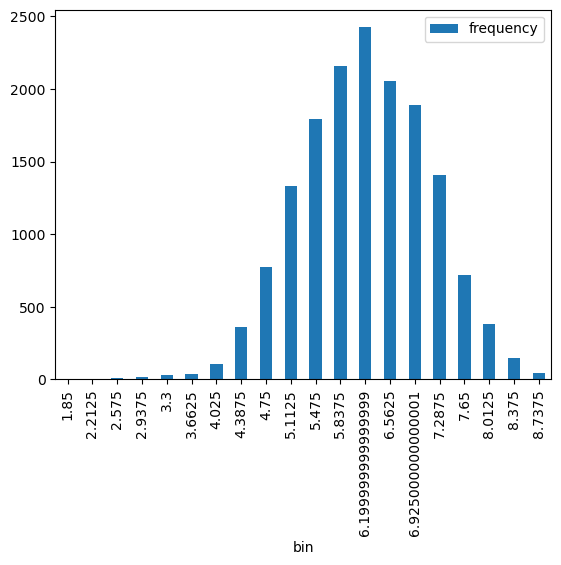

In [6]:
from pyspark.sql.functions import min, max
import pandas as pd 
df.select(min("Score"), max("Score")).show()
print(f"Column sparsity: {sparsity_list["Score"]}")

gre_histogram = df.select("Score").filter(col("Score").cast("float").isNotNull())\
    .rdd.flatMap(lambda x: x)\
    .map(float)\
    .histogram(20)

pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index('bin').plot(kind='bar')

Sparsity: 63%, low. Value representation on non-skewed normal distribution with mean around 6.2.

#### Genres (finished)

Since the column is categorical and the label order in Genres is not important, we use one-hot encoding.

In [7]:
df = oneHotEncoding(df, "Genres")

Fill rate: 24905/24905
{'Action', 'Boys Love', 'Gourmet', 'Drama', 'Sports', 'Adventure', 'Mystery', 'Suspense', 'Horror', 'Girls Love', 'Ecchi', 'Romance', 'Hentai', 'Avant Garde', 'Erotica', 'Fantasy', 'Comedy', 'Sci-Fi', 'Supernatural', 'Award Winning', 'Slice of Life'}


+--------------------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+
|              Genres|Action|Boys Love|Gourmet|Drama|Sports|Adventure|Mystery|Suspense|Horror|Girls Love|Ecchi|Romance|Hentai|Avant Garde|Erotica|Fantasy|Comedy|Sci-Fi|Supernatural|Award Winning|Slice of Life|
+--------------------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+
|Comedy, Drama, Fa...|     0|        0|      0|    1|     0|        0|      0|       0|     0|         0|    1|      1|     0|          0|      0|      1|     1|     0|           0|            0|            0|
|Drama, Sci-Fi, Su...|     0|        0|      0|    1|     0|        0|      0|       0|     0|         0|    0|      0|     0|          0|      0|      0|     0

25/03/16 17:24:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-----+-------+--------+--------------------+-----------+---------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+
|anime_id|Score|   Type|Episodes|               Aired|  Premiered|         Status|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|Members|           Image URL|Action|Boys Love|Gourmet|Drama|Sports|Adventure|Mystery|Suspense|Horror|Girls Love|Ecchi|Romance|Hentai|Avant Garde|Erotica|Fantasy|Comedy|Sci-Fi|Supernatural|Award Winning|Slice of Life|
+--------+-----+-------+--------+--------------------+-----------+---------------+--------------------+-

#### Type (finished)

Similar to Genres, we use one-hot encoding here.

In [8]:
df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|   NULL|   74|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Since only 0.3% of samples have empty values, so we should have no problem dropping these rows.

In [9]:
df = df.filter("Type is not NULL")
df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Then we perform one-hot encoding

In [10]:
df = oneHotEncoding(df, "Type")

Fill rate: 24831/24831


{'ONA', 'OVA', 'Music', 'Special', 'Movie', 'TV'}
+-------+---+---+-----+-------+-----+---+
|   Type|ONA|OVA|Music|Special|Movie| TV|
+-------+---+---+-----+-------+-----+---+
|     TV|  0|  0|    0|      0|    0|  1|
|Special|  0|  0|    0|      1|    0|  0|
|    OVA|  0|  1|    0|      0|    0|  0|
|  Music|  0|  0|    1|      0|    0|  0|
|  Movie|  0|  0|    0|      0|    1|  0|
|    ONA|  1|  0|    0|      0|    0|  0|
+-------+---+---+-----+-------+-----+---+



+--------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+---+---+-----+-------+-----+---+
|anime_id|Score|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|Members|           Image URL|Action|Boys Love|Gourmet|Drama|Sports|Adventure|Mystery|Suspense|Horror|Girls Love|Ecchi|Romance|Hentai|Avant Garde|Erotica|Fantasy|Comedy|Sci-Fi|Supernatural|Award Winning|Slice of Life|ONA|OVA|Music|Special|Movie| TV|
+--------+-----+--------+--------------------+--------

#### Episodes

#### Aired (finished)

The format is in the form of "(start date) to (end date)", so we perform splitting into two columns.

In [11]:
# column: Aired 
from pyspark.sql.functions import split, to_date

split_col = split(df["Aired"], " to ", 2)
df = df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
df = df.withColumn("air_start", to_date(col("F1"), "MMM d, yyyy"))\
    .withColumn("air_end", to_date(col("F2"), "MMM d, yyyy"))\
    .drop("F1", "F2", "Aired")
df.select("air_start", "air_end").show()

+----------+-------+
| air_start|air_end|
+----------+-------+
|      NULL|   NULL|
|2005-09-14|   NULL|
|1989-03-11|   NULL|
|2023-07-03|   NULL|
|2008-11-29|   NULL|
|2022-10-14|   NULL|
|2022-12-30|   NULL|
|2021-07-09|   NULL|
|2022-08-19|   NULL|
|2022-06-11|   NULL|
|      NULL|   NULL|
|2021-07-02|   NULL|
|2021-10-30|   NULL|
|      NULL|   NULL|
|2020-10-01|   NULL|
|2020-02-01|   NULL|
|2019-08-23|   NULL|
|2019-08-09|   NULL|
|2022-02-04|   NULL|
|2019-02-15|   NULL|
+----------+-------+
only showing top 20 rows



In some cases, some titles do not have both timestamps.

In [12]:
print(df.select("air_start", "air_end").where("air_start is not NULL").count())
print(df.select("air_start", "air_end").where("air_end is not NULL").count())
print(df.select("air_start", "air_end").where("air_start is not NULL AND air_end is not NULL").count())
print(df.count())

20088


9337


9317


24831


Since the number of missing values is huge for both columns and users can manually filter the recommendation rankings, our choice is to drop the columns in processing.

In [13]:
df = df.drop("air_start", "air_end")
df.show()

+--------+-----+--------+-----------+----------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+---+---+-----+-------+-----+---+
|anime_id|Score|Episodes|  Premiered|          Status|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|Members|           Image URL|Action|Boys Love|Gourmet|Drama|Sports|Adventure|Mystery|Suspense|Horror|Girls Love|Ecchi|Romance|Hentai|Avant Garde|Erotica|Fantasy|Comedy|Sci-Fi|Supernatural|Award Winning|Slice of Life|ONA|OVA|Music|Special|Movie| TV|
+--------+-----+--------+-----------+----------------+--------------------+--------------------+

#### Premiered

#### Status, Producers, Licensors, Studios, Source (finished)

Similar to some Genres and Type, we shall one-hot encode these features.

In [14]:
df = oneHotEncoding(df, "Status", show=False)
df = oneHotEncoding(df, "Producers", show=False)
df = oneHotEncoding(df, "Licensors", show=False)
df = oneHotEncoding(df, "Studios", show=False)
df = oneHotEncoding(df, "Source", show=False)

df.show()

{'Currently Airing', 'Not yet aired', 'Finished Airing'}


{'TEAM Entertainment Inc.', 'Asahi Shimbun', 'Public & Basic', 'G&G Entertainment', 'Quaras', 'Magilm Pictures', 'Trans Cosmos', 'Geijutsu Eigasha', 'DMM.com Labo', 'Hiroshi Planning', 'FuRyu', 'USEN', 'Allure', 'Yomiuri TV Enterprise', 'RAY', 'Kitty Film Mitaka Studio', 'Anime R', 'KAGAYA Studio', 'Sunrise', 'Flex Comix', 'Happinet Media Marketing', 'AT-X', "Steve N' Steven", 'Apollon', 'Fuji TV', 'Postgal Workshop', 'Knack Animation', 'Shizuoka Asahi Television', 'HoriPro International', 'USERJOY Technology', 'Jumondo', 'Strawberry Meets Pictures', 'T.P.O', 'Akabanten', 'Geidai Animation', 'Dentsu Eigasha Tokyo', 'NHK-BS2', 'Marine Entertainment', 'OLM', 'KBS Kyoto', 'Visual Vision', 'CyberAgent', 'NewGin', 'Links', 'Stay Luck', 'Hobby Japan', 'ChiChinoya', 'Discovery', 'Animaruya', 'Asmik Ace', 'Toshiba Entertainment', 'Hawkeye', 'TV Kanagawa', 'Maxilla', 'Marui Group', 'Grooove', 'Green Bunny', 'APDREAM', 'Shueisha', 'Media Station', 'Studio Tron', 'Kakao Japan', 'Hiro Media', 'Ani

25/03/16 17:25:54 WARN TaskSetManager: Stage 278 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:26:01 WARN TaskSetManager: Stage 299 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.


{'Marvel Entertainment', 'Manga Entertainment', 'ADK Emotions NY', 'VIZ Media', 'bilibili', 'Anime Midstream', 'Cookie Jar Entertainment', 'Ketchup Entertainment', 'Capcom', 'Bandai Namco Online', 'Urban Vision', 'Pied Piper', 'Mill Creek Entertainment', 'Kuma Holdings', 'Illumitoon Entertainment', 'Frontier Works', 'AN Entertainment', 'Crimson Star Media', 'Cinelicious Pics', 'Funimation', 'Arts Magic', 'Maiden Japan', 'Ascendent Animation', 'NBCUniversal Entertainment Japan', 'Geneon Entertainment USA', 'Saban Brands', 'Bandai', 'Central Park Media', 'Enoki Films', 'Super Techno Arts', 'Streamline Pictures', 'Directions', 'Warner Bros. Pictures', 'SoftCel Pictures', 'Shout! Factory', 'Kadokawa', 'Geneon Universal Entertainment', 'Nelvana', 'NuTech Digital', 'NIS America', 'Tokyopop', 'Saban Entertainment', 'Flatiron Film Company', 'iQIYI', 'Sony Pictures Entertainment', 'Nintendo of America', 'B.CMAY PICTURES', '4Kids Entertainment', 'Sentai Filmworks', 'Dentsu Entertainment USA', 'S

25/03/16 17:26:07 WARN TaskSetManager: Stage 314 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:26:13 WARN TaskSetManager: Stage 335 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:26:20 WARN TaskSetManager: Stage 359 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.


{'Gallop', 'Image House', 'Remic', 'GANSIS', 'Qingxiang Culture', 'Deck', 'Vega Entertainment', 'Studio Deen', 'Scooter Films', 'Academy Productions', 'Studio Kelmadick', 'Office AO', 'Borutong', 'HOTZIPANG', 'HIDEHOMARE', 'Bee Train', 'Public & Basic', 'Gainax', 'Picona', 'Hotline', 'Drive', 'Revoroot', 'G&G Entertainment', 'Shimogumi', 'W+K Tokyo', 'MontBlanc Pictures', 'Studio Crocodile', 'Studio Blanc.', 'TMS Entertainment', 'Indivision', 'Drawing and Manual', 'LandQ studios', 'FOREST Hunting One', 'The Monk Studios', 'C&S Production', 'Pony Canyon', 'Uguisu Kobo', 'Emon', 'Polygon Pictures', 'Namu Animation', 'Agent 21', 'Studio UGOKI', 'LX Animation Studio', 'Success Corp.', 'Group TAC', 'Ether Kitten', 'Kino Production', 'Shinkuukan', 'AIC', 'Studio Pivote', 'Hai An Xian Donghua Gongzuo Shi', 'Sonsan Kikaku', 'Ascension', 'Kaca Entertainment', 'Stereotype', 'Tokyo Kids', 'Brians Film', 'Kitty Film Mitaka Studio', 'Guton Animation Studio', 'Anime R', 'Ruo Hong Culture', 'Bouncy',

25/03/16 17:26:26 WARN TaskSetManager: Stage 377 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:26:46 WARN TaskSetManager: Stage 401 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:26:53 WARN TaskSetManager: Stage 428 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.


{'Manga', 'Visual novel', '4-koma manga', 'Game', 'Web novel', 'Music', 'Mixed media', 'Web manga', 'Picture book', 'Book', 'Original', 'Novel', 'Other', 'Radio', 'Light novel', 'Card game'}


25/03/16 17:27:00 WARN TaskSetManager: Stage 449 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:27:10 WARN TaskSetManager: Stage 478 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1315.5 KiB


+--------+-----+--------+-----------+-------------+--------------------+-------+----------+---------+---------+-------+--------------------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+---+---+-----+-------+-----+---+----------------+-------------+---------------+-----------------------+-------------+--------------+-----------------+------+---------------+------------+----------------+------------+----------------+-----+----+------+---------------------+---+------------------------+-------+-------------+-------+----------+------------------------+----+---------------+-------+-------+----------------+---------------+-------------------------+---------------------+------------------+-------+-------------------------+-----+---------+----------------+--------------------+-------+--------------------+---+---------+-------------+----------+------+-----

#### Duration

The format is "? hr ? min (per ep)", we shall convert to a single number representing the duration for each episode in minutes.

In [15]:
temp_df = df.select("Duration")
temp_df.show()

25/03/16 17:29:05 WARN TaskSetManager: Stage 530 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.


+-------------+
|     Duration|
+-------------+
|         NULL|
|        5 min|
|       24 min|
|  1 hr 36 min|
|  1 hr 35 min|
|  1 hr 35 min|
|  1 hr 43 min|
|   1 hr 1 min|
|  1 hr 33 min|
|  1 hr 22 min|
|       50 min|
|  1 hr 50 min|
|       22 min|
|         1 hr|
|   1 hr 6 min|
|  1 hr 18 min|
|         1 hr|
| 3 min per ep|
|10 min per ep|
|  1 hr 43 min|
+-------------+
only showing top 20 rows



#### Rating (finished)

This feature shall be used to filter the recommendation list by user's age and/or filter options, hence it is not to be in the processing.

In [16]:
df = df.drop("Rating")

#### Rank

#### Popularity

#### Favorites

#### Scored By

#### Members

#### Image URL (finished)

The feature has nothing to do with data processing, so the column is expected to be removed.

In [17]:
df = df.drop("Image URL")

#### Final results

In [18]:
df.show()

25/03/16 17:29:18 WARN TaskSetManager: Stage 561 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1312.4 KiB


+--------+-----+--------+-----------+-------------+-------+----------+---------+---------+-------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+---+---+-----+-------+-----+---+----------------+-------------+---------------+-----------------------+-------------+--------------+-----------------+------+---------------+------------+----------------+------------+----------------+-----+----+------+---------------------+---+------------------------+-------+-------------+-------+----------+------------------------+----+---------------+-------+-------+----------------+---------------+-------------------------+---------------------+------------------+-------+-------------------------+-----+---------+----------------+--------------------+-------+--------------------+---+---------+-------------+----------+------+-----+---------+-----------+----------+--------

In [19]:
#spark.stop()